In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import DBSCAN
import seaborn as sns

#Données dans un dataframe
df_real = pd.read_csv("director_avg.csv", sep=";", low_memory=False)
#on enlève les colonnes inutiles
df_real.drop('movie_nb_inclnodate', axis=1, inplace=True)
df_real.drop('max_date', axis=1, inplace=True)

In [2]:
#chargement du fichier avec les fidélité rel
df_real2 = pd.read_csv("director_attr.csv", sep=";", low_memory=False)
#On vire les colonnes inutiles
df_real2.drop(["movies_nb", "fidelity_abs"],axis=1,inplace=True)
#nettoyage des directeurs avec \t dans le nom, pour pouvoir faire la jointure avec df_real2
df_real["director_name"]=df_real["director_name"].str.replace("\t","")
df_real2["director_name"]=df_real2["director_name"].str.replace("\t","")
df_real=pd.merge(df_real,df_real2,on="director_name")

# Boxplot

In [3]:
#plt.hist(df_real["vote_count"], bins=[0, 100, 300, 500, 800, 1500, 5000,10000])


(array([ 82597.,   1657.,    455.,    349.,    311.,    368.,    115.]),
 array([    0,   100,   300,   500,   800,  1500,  5000, 10000]),
 <a list of 7 Patch objects>)

In [4]:
#Proposition 1 : on ne garde que ceux qui ont >100 votes et qui ont effectivement sorti un film (min_date<2017)
df_real2 = df_real[np.logical_and(df_real["vote_count"]>100,df_real["min_date"]<2017)]
#Proposition 2 : on garde ceux qui ont moins de 100 films + au moins 1 film
df_real2 = df_real2[np.logical_and(df_real2["movie_nb"]<100, df_real2["movie_nb"]>1)]
#Proposition 3 : on garde les réal qui ont une moyenne de runtime <300
df_real2 = df_real2[df_real2["runtime"]<300]
#Proposition 4 : on garde les 250 réalisateurs dont les films sont en moyenne les mieux notés
df_real2.sort_values(by = "vote_average", ascending=False,inplace = True)
df_real3 = df_real2.iloc[0:250]
#Stockage dans un fichier des noms de réal pour le clustering via résumé wikipedia
df_real3["director_name"].to_csv("top250_acclaimed_directors.csv",encoding='utf-8', sep=";")

df_real3 = df_real2
df_real2.drop("id",axis=1,inplace=True)


# Matrice de correlation

In [58]:
#test : on simplifie un peu pour voir si les genres / langages n'éparpillent pas un peu trop les datas
# df_real2= df_real2.drop(["career_middle_date", "runtime","production_companies_number","production_countries_number"
#                        ,"spoken_languages_number","Drama","Crime","Action","Documentary","Adventure","Animation","Comedy"
#                        ,"Mystery","Fantasy","Horror","Western","Science Fiction","Thriller","Romance"
#                        ,"War","Family","Music","History","TV Movie","Foreign",'en','de','fr','es','pt',
#                         'ja','it','zh','sv','da','other'], axis=1)

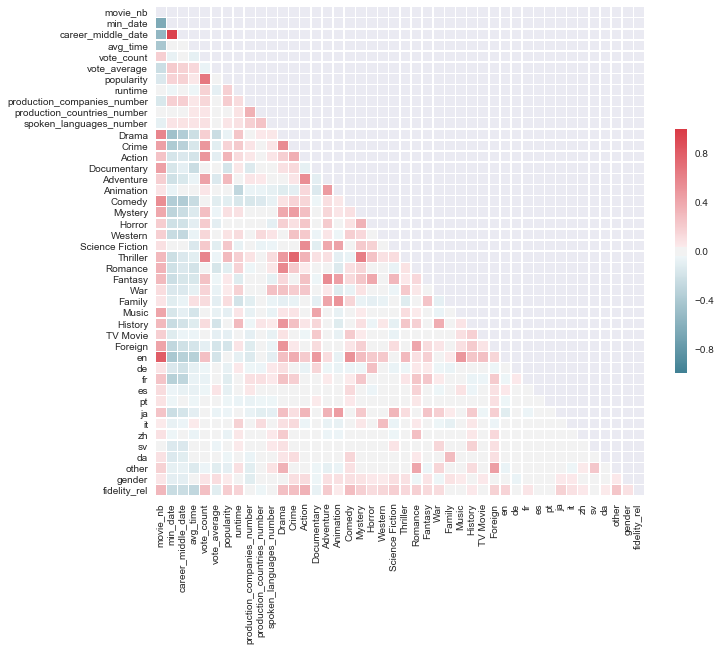

In [10]:
# calcul et affichage de la matrice de correl
corr = df_real2.corr()
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap=cmap, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('matrice.png',bbox_inches='tight')
plt.show()

# PCA

In [12]:
# split data table into data X
X = df_real2.drop("director_name", axis=1).loc[:,:]
X_std = StandardScaler().fit_transform(X)
sklearn_pca = sklearnPCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X_std)
sklearn_pca.explained_variance_ratio_

array([ 0.14161329,  0.08075877,  0.06882199,  0.05416865,  0.04261473])

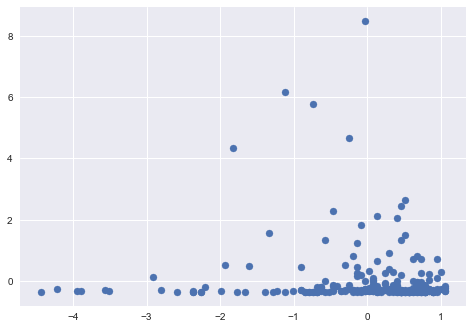

In [19]:

#Conclusion : les 10 premiers composants comptent pour seulement 53% de la variance 
#Ce qui confirme une matrice relativement "vide" de correlation
#=> pas probant comme réduction de dimension
xs = X_std[:,1]
ys = X_std[:,4]
plt.scatter(xs,ys)
plt.show()
#eh ouais, pas de paquet :(

In [26]:
#look further into our first component- which variables were most important to the first component?
first_comp = sklearn_pca.components_[0]
first_comps = pd.DataFrame(list(zip(first_comp, X.columns)), columns=['weights', 'features'])
first_comps['abs_weights']=first_comps['weights'].apply(lambda x: np.abs(x))
first_comps.sort_values(by = 'abs_weights', ascending=False)

,weights,features,abs_weights
0,0.344317,movie_nb,0.344317
11,0.289375,Drama,0.289375
1,-0.286917,min_date,0.286917
12,0.264632,Crime,0.264632
31,0.253515,en,0.253515
2,-0.248537,career_middle_date,0.248537
18,0.230710,Mystery,0.230710
22,0.227037,Thriller,0.227037
13,0.201121,Action,0.201121
43,0.186535,fidelity_rel,0.186535


# Clustering

In [45]:
#df_tr = df_real[0:10000]
df_tr = df_real2
#liste des noms de réals en numpy array
director_names = df_tr['director_name'].values
#Exclusion des noms de réals (non numériques) pour le travail de clustering
df_tr2 = df_tr.iloc[:,1:]
#convert to numpy array
df_tr2 = df_tr2.values.astype(int)
#méthode de normalisation choisie sans réfléchir, à revoir
scaler = StandardScaler()
#On cherche 10 clusters
model = KMeans(n_clusters=10)
#On rassemble tout pour aller plus vite
pipeline = make_pipeline(scaler,model)
#on fitte les modèles aux données et on les transforme
labels = pipeline.fit_predict(df_tr2)

C:\Users\rapno\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [63]:
df_tr["labels"]=labels

In [72]:
df_tr[df_tr["labels"]==5]

,director_name,movie_nb,min_date,career_middle_date,avg_time,vote_count,vote_average,popularity,runtime,production_companies_number,...,pt,ja,it,zh,sv,da,other,gender,fidelity_rel,labels
45558,Lake Bell,4,2010,2013,2.2,226,8.200000,0.409312,38.333333,2.250000,...,0,0,0,0,0,0,0,1.0,0.8,5
47971,Louis D'Esposito,2,2012,2012,1.5,277,8.033333,1.237995,13.500000,1.000000,...,0,0,0,0,0,0,0,2.0,0.0,5
50273,Marco Berger,10,2008,2012,1.0,111,8.020000,0.208281,80.800000,2.142857,...,0,0,0,0,0,0,0,2.0,1.0,5
38580,John Kahrs,2,2012,2014,3.0,685,8.000000,0.691037,7.000000,2.000000,...,0,0,0,0,0,0,0,2.0,0.0,5
543,Adam Curtis,19,1984,2000,1.8,130,7.964286,0.067360,110.578947,1.142857,...,0,0,0,0,0,0,0,2.0,0.1,5
83529,Yann Arthus-Bertrand,16,2008,2011,0.6,293,7.957143,0.256277,120.000000,1.714286,...,0,0,1,0,0,0,0,2.0,0.0,5
7708,Banksy,2,2010,2010,1.5,304,7.900000,0.172877,45.333333,2.000000,...,0,0,0,0,0,0,0,2.0,0.0,5
43804,Kerry Conran,3,2004,2008,3.3,413,7.850000,0.889474,39.666667,3.500000,...,0,0,0,0,0,0,0,2.0,0.0,5
71212,Saschka Unseld,3,2013,2014,1.7,177,7.800000,0.163498,7.500000,1.000000,...,0,0,0,0,0,0,0,2.0,0.0,5
61647,Paul Dugdale,11,2011,2014,0.7,111,7.800000,0.213799,94.181818,1.111111,...,0,0,0,0,0,0,0,2.0,1.5,5


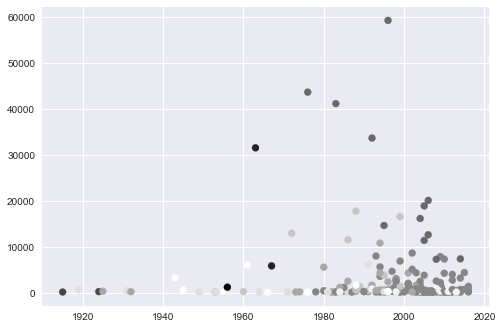

In [24]:
#on trace le graphe pour deux features, en espérant mettre en évidence les clusters (indiqués par des couleurs différentes). Pour l'instant, seulement des graphes "plats", donc la normalisationn'est sans doute pas bonne.
#Features choisies ici: movie_nb en abscisse, min_date en ordonnée
xs = df_tr2[:,1]
ys = df_tr2[:,4]
plt.scatter(xs,ys,c=labels)
plt.show()

In [9]:
#création de dataframe avec les labels de clusters et les noms de réals
df_f = pd.DataFrame({'labels':labels,'Dir_names':director_names})
#retourne un tableau avec les 10 catégories en row, les réalisateurs en colonnes, avec valeur 1 pour la catégorie à laquelle ils appartiennent. On peut en tirer les gorupes de réals mais je n'ai plus le temps.
ct = pd.crosstab(df_f['labels'],df_f['Dir_names'])